author: @SteveEckel

This script shows examples about how to solve for the dynamics of a 1D MOT and
calculate things like the capture velocity.  We will deal specifically with a 1D MOT.
We can compare results to those of 1 D. Haubrich, A. Höpe, and D. Meschede, “A simple model for optical capture of atoms in strong magnetic quadrupole fields” _Optics Communications_ __102__, 225 (1993).  http://dx.doi.org/10.1016/0030-4018(93)90387-K

In this example, we will mostly focus on the heuristic force equation for an $F=0\rightarrow F'=1$ atom in a magnetic field:

$$
F = \frac{\hbar k \Gamma}{2}\sum_{q,i} \frac{\beta_i (\epsilon_q \cdot \hat{B}(r))^2}{1+\sum_j\beta_j + 4[\Delta - \mathbf{k}_i\cdot \mathbf{v} - q \hbar \mu_B B(r)]^2/\Gamma^2}
$$

where $F$ is the force, $\Gamma$ is the decay, $q=-1,0,1$, $\beta_i$ and $\mathbf{k}_i$ are the intensity and wavevector of the $i$th laser beam (which can depend on time $t$ and position $\mathbf{r}$.  This equation is encoded in `pylcp.heuristiceq`. 

We'll use the standard 3D MOT quadrupole field,

$$
\mathbf{B} = B'\left(-\frac{1}{2}(x\hat{x} + y\hat{y})+z\hat{z}\right)
$$

where $B'$ is the magnetic field gradient.

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import fsolve
import scipy.constants as cts
import pylcp
import pylcp.atom as atom
from pylcp.common import bisectFindChangeValue, progressBar
plt.style.use('paper')

### Let's now set up the units:
As with any problem in `pylcp`, the units that one chooses are arbitrary.  We will denote all explicit units with a subscript and all quantities where we have removed the units with anoverbar, e.g. $\bar{x} = x/x_0$.  Here, let's choose units where the term in the sum is simply given by (along the $\hat{z}$ axis):

$$
\frac{\beta_i (\epsilon_q \cdot \hat{B}(r))^2}{1+\sum_j\beta_j + 4(\delta - \hat{\mathbf{k}}_i\cdot \mathbf{\bar{v}} - q \bar{z})^2}
$$
where $\delta = \Delta/\Gamma$.  Note that in order to reproduce the equation above, I would choose $\Gamma=1$ and $k=1$.

Thus, we shall choose as our length unit $x_0 = \Gamma/\hbar \mu_B B'$ and $t_0$ such that

$$
\bar{v} = \frac{k v}{\Gamma}  = k \frac{x_0}{\Gamma t_0}\bar{v}
$$

implying that

$$
t_0 = \frac{k x_0}{\Gamma}
$$

The $\mathbf{k}$ vector is a bit unique in this problem, as we need to specify it in terms of our special units.  In this case

$$
\bar{\mathbf{k}} = \mathbf{k} x_0 = \frac{2\pi}{\lambda}\frac{\Gamma}{\hbar \mu_B B'}
$$

Let's consider the specific case of Rb, where $\lambda=780$ nm, $\Gamma=2\pi\times 6$ MHz, $\hbar \mu_B = 2\pi\times 1.4$ MHz/G, and $B'\approx 15$ G/cm.  Plugging in the numbers,

In [2]:
x0 = (6/1.4/15) # cm
k = 2*np.pi/780E-7 # cm^{-1}
kbar = k*x0

gamma = 2*np.pi*6e6
t0 = k*x0/gamma
print(x0, k, kbar, 1/gamma, t0)

0.2857142857142857 80553.65778435367 23015.33079552962 2.6525823848649224e-08 0.0006105006105006105


Finally, we need the mass, which is defined through this equation:

$$
\ddot{\mathbf{r}} = \frac{\mathbf{F}}{m} = \frac{\hbar k \Gamma}{m}\hat{\mathbf{k}}
$$

Note that I neglected the sum, since that is dimensionless already.  I can now put in the units explicitly:

$$
\frac{x_0}{t_0^2} \ddot{\bar{\mathbf{r}}} = \frac{\hbar k \Gamma }{m}\hat{\mathbf{k}}
$$

Rearranging,

$$
\ddot{\bar{\mathbf{r}}} = \frac{\hbar k \Gamma t_0^2}{m x_0} \hat{\mathbf{k}} = \frac{\hbar k^2 t_0}{m}\hat{\mathbf{k}}
$$

where now the above equation looks like $\bar{m} = m/(\hbar k^2 t_0)$.

Note that the mass of Rb atom is 86.909180527 u.

In [3]:
mass = 86.909180527*cts.value('atomic mass constant')/(cts.hbar*(k*1e2)**2*t0)
print(mass)

0.03454474231473474


### First, we define the simple problem:

In [33]:
det = -1.5
alpha = 1.0
beta = 1.0

laserBeams = pylcp.laserBeams([
    {'kvec':np.array([0., 0., 1.]), 'pol':np.array([0., 0., 1.]), 'beta':beta, 'delta':det},
    {'kvec':np.array([0., 0., -1.]), 'pol':np.array([1., 0., 0.]), 'beta':beta, 'delta':det}],
    beam_type=pylcp.infinitePlaneWaveBeam
)

magField = pylcp.quadrupoleMagneticField(alpha)

heuristic = pylcp.heuristiceq(laserBeams, magField, gamma=1, mass=mass)

### Now compute the background force profile:

In [34]:
dz = 0.1
dv = 0.1
z = np.arange(-20, 20+dz, dz)
v = np.arange(-20, 20+dv, dv)

Z, V = np.meshgrid(z, v)

Rfull = np.array([np.zeros(Z.shape), np.zeros(Z.shape), Z])
Vfull = np.array([np.zeros(Z.shape), np.zeros(Z.shape), V])

heuristic.generate_force_profile([np.zeros(Z.shape), np.zeros(Z.shape), Z],
                                 [np.zeros(V.shape), np.zeros(V.shape), V], name='Fz')

Plot 'er up:

Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


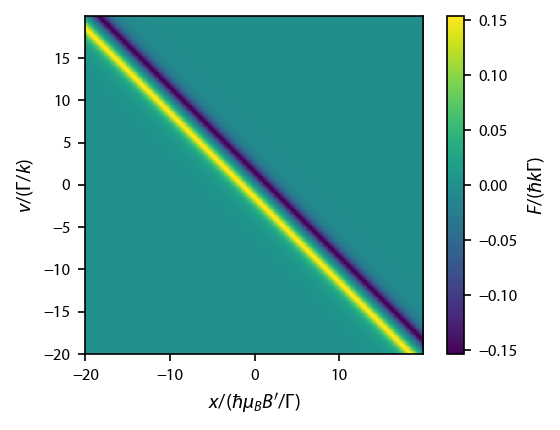

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(4, 2.75))
plt.imshow(heuristic.profile['Fz'].F[2], origin='bottom',
           extent=(np.amin(z)-dz/2, np.amax(z)-dz/2,
                   np.amin(v)-dv/2, np.amax(v)-dv/2))
cb1 = plt.colorbar()
cb1.set_label('$F/(\hbar k \Gamma)$')
ax.set_xlabel('$x/(\hbar \mu_B B\'/\Gamma)$')
ax.set_ylabel('$v/(\Gamma/k)$')
fig.subplots_adjust(left=0.12,right=0.9)

### Now, let's add in trajectories in phase space:

The first thing to do is define a stop condition, when the velocity of the atom gets to be too small.

In [36]:
v0s = np.arange(1, 10.5, 1)

# See solve_ivp documentation for event function discussion:
def captured_condition(t, y, threshold=1e-5):
    if(y[2]<threshold and y[-1]<1e-3):
        val = -1.
    else:
        val = 1.
    
    return val

def lost_condition(t, y, threshold=1e-5):
    if y[-1]>20.:
        val = -1.
    else:
        val = 1.
    
    return val

captured_condition.terminal=True
lost_condition.terminal=True

sols = []
for v0 in v0s:
    heuristic.set_initial_position_and_velocity(np.array([0., 0., z[0]]),
                                                np.array([0., 0., v0]))
    heuristic.evolve_motion([0., 100.], events=[captured_condition, lost_condition], max_step=0.1)
    
    sols.append(heuristic.sol)

Now, plot it up:

(-20, 20)

Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


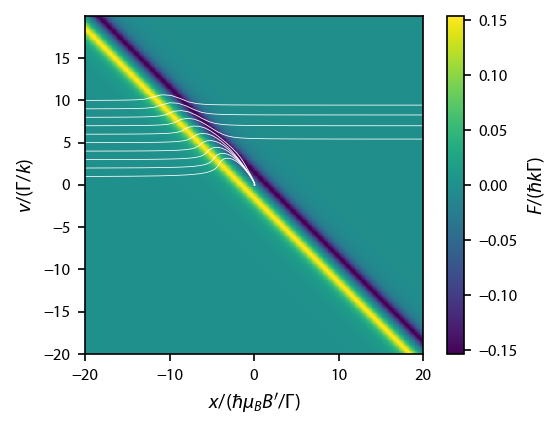

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(4, 2.75))
plt.imshow(heuristic.profile['Fz'].F[2], origin='bottom',
           extent=(np.amin(z)-dz/2, np.amax(z)-dz/2,
                   np.amin(v)-dv/2, np.amax(v)-dv/2))
cb1 = plt.colorbar()
cb1.set_label('$F/(\hbar k \Gamma)$')
ax.set_xlabel('$x/(\hbar \mu_B B\'/\Gamma)$')
ax.set_ylabel('$v/(\Gamma/k)$')
fig.subplots_adjust(left=0.12,right=0.9)

for sol in sols:
    ax.plot(sol.r[2], sol.v[2], 'w-', linewidth=0.375)

# Display the figure at the end of the thing.
ax.set_xlim((-20, 20))
ax.set_xlim((-20, 20))

By having two conditions, we can tell if the atom was lost or captured:

In [38]:
for sol in sols:
    if len(sol.t_events[0]) == 1:
        print('captured')
    elif len(sol.t_events[1]) == 1:
        print('lost')

captured
captured
captured
captured
captured
captured
lost
lost
lost
lost


### Now, let's get even more fancy:

Let's define a function that figures out if we were captured or not, then use that to find the capture velocity:

In [10]:
def iscaptured(v0, z0, eqn, captured_condition, lost_condition, tmax=1000, **kwargs):
    eqn.set_initial_position_and_velocity(np.array([0., 0., z0]),
                                          np.array([0., 0., v0]))
    eqn.evolve_motion([0., tmax], events=[captured_condition, lost_condition],
                      **kwargs)
    
    return len(eqn.sol.t_events[0]) == 1

iscaptured(6.1, -20., heuristic, captured_condition, lost_condition, tmax=1000, max_step=0.1)

True

See if we can find out where it changes:

In [11]:
bisectFindChangeValue(iscaptured, 6.0,
                      args=(z[0], heuristic, captured_condition, lost_condition),
                      kwargs={'tmax':1000, 'max_step':0.1},
                      tol=1e-5
                     )

(6.207481384277344, 19)

### Let's run the detuning and intensity:

In [26]:
dets = -np.logspace(-1, np.log10(5), 10)[::-1]
betas = np.array([0.5, 1., 2., 4.])

DETS, BETAS = np.meshgrid(dets, betas)

it = np.nditer([DETS, BETAS, None, None])

progress = progressBar()
for (det, beta, vc, iterations) in it:
    laserBeams = pylcp.laserBeams([
        {'kvec':np.array([0., 0., 1.]), 'pol':np.array([0., 0., 1.]), 'beta':beta, 'delta':det},
        {'kvec':np.array([0., 0., -1.]), 'pol':np.array([1., 0., 0.]), 'beta':beta, 'delta':det}],
        beam_type=pylcp.infinitePlaneWaveBeam
    )

    heuristic = pylcp.heuristiceq(laserBeams, magField, gamma=1, mass=mass)
    
    vc[...], iterations[...] = bisectFindChangeValue(
        iscaptured, 5.0,
        args=(z[0], heuristic, captured_condition, lost_condition),
        kwargs={'tmax':1000, 'max_step':0.1},
        tol=1e-5
    )

    progress.update((it.iterindex+1)/it.itersize)

/Users/steve/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/steve/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Completed in 14:18.                                                 


Text(0, 0.5, '$v_c/(\\Gamma/k)$')

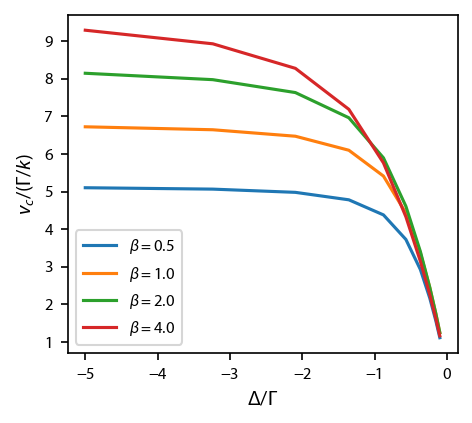

In [31]:
fig, ax = plt.subplots(1, 1)
for (beta, vc_vs_det) in zip(betas, it.operands[2]):
    ax.plot(dets, vc_vs_det, label='$\\beta=%.1f$' % beta)
ax.legend(fontsize=8)
ax.set_xlabel('$\Delta/\Gamma$')
ax.set_ylabel('$v_c/(\Gamma/k)$')